# 目的
あるクラウドファンディングが成功するか(state)を事前に予測するモデルを構築する。

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.metrics import log_loss

# データの読み込み

## データの扱いについて
| Variables | 変数 | 使う? | 変数の扱い |
| ---- | ---- | ---- |  ---- |
| ID | internal kickstarter id | - | - |
| name | プロジェクト名 | - | - |
| category | カテゴリー | ○ | ダミー変数 |
| main_category | category of campaign | ○ | ダミー変数 |
| currency | 通貨 | ○ | ダミー変数 |
| deadline | 期限 | ○ (開始日 - 期限 の募集機関で使ってみる) | 数値(日数) |
| goal | 目標金額 | ○ | 数値(金額) |
| launched | 開始日 | ○ (開始日 - 期限 の募集機関で使ってみる) | 数値(日数) |
| pledged | 集まった金額 | - (開始時にはわからないので使わない) | - |
| state | 成否 | ※目的変数 | fiailled: 0, successful: 1, Other: 捨てる(Pandasで) |

↓必要な項目を抜き出して読み込み、データの整形を行う。

In [6]:
ks_projects_data = pd.read_csv("ks-projects-201801.csv")[['category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'state']]

# state が failed と successful 以外の行を削除 
# SettingWithCopyWarningがでるので copy() する
# indexが連番じゃなくなるので reset_index() で連番に直す
ks_projects_data2 = ks_projects_data[(ks_projects_data['state'] == 'failed') | (ks_projects_data['state'] == 'successful')].copy().reset_index(drop=True)

# 欠損値が無いことを確認
#ks_projects_data2.info()

# deadline - launched で募集期間を算出する
# pd.to_datetime() を使って、str を datetime64型に変換
# 日数(int)で出したいので、Series.dt() を使って変換
ks_projects_data2['launched'] = pd.to_datetime(ks_projects_data2['launched'], format='%Y-%m-%d %H:%M:%S')
ks_projects_data2['deadline'] = pd.to_datetime(ks_projects_data2['deadline'], format='%Y-%m-%d %H:%M:%S')
ks_projects_data2['duration'] = (ks_projects_data2['deadline'] - ks_projects_data2['launched']).dt.days

display(ks_projects_data2.head())

# 質的変数(category, main_category, currency) のユニークな値の確認
# categoryの数が多すぎてメモリに載らないため、一旦 category を外して考える
#ks_projects_data2['currency'].value_counts()  # 14
#ks_projects_data2['category'].value_counts()  # かなり多い
#ks_projects_data2['main_category'].value_counts()  # 15

# category, launched, deadlineを外す
ks_projects_data3 = ks_projects_data2.drop(['category', 'launched', 'deadline'], axis=1)
#display(ks_projects_data3.head())

# state を succesful = 1, failed = 0 に置換する
ks_projects_data3 = ks_projects_data3.replace({'state': {'failed': 0, 'successful': 1}})
display(ks_projects_data3.head())

# main_category と currency をダミー変数に変換する
ks_projects_data4 = pd.get_dummies(ks_projects_data3)
display(ks_projects_data4.head())


,category,main_category,currency,deadline,goal,launched,state,duration
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,58
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,59
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,44
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,29
4,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,successful,34


,main_category,currency,goal,state,duration
0,Publishing,GBP,1000.0,0,58
1,Film & Video,USD,30000.0,0,59
2,Film & Video,USD,45000.0,0,44
3,Music,USD,5000.0,0,29
4,Food,USD,50000.0,1,34


,goal,state,duration,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,1000.0,0,58,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,30000.0,0,59,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,45000.0,0,44,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,5000.0,0,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,50000.0,1,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
# numpy配列に変換
y = ks_projects_data4['state'].values
X = ks_projects_data4.drop('state', axis=1).values

clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
print("w0 = {:.3f}".format(w0))

wn = []
for i in range(len(clf.coef_[0])):
    wn.append(clf.coef_[0,i])
    print("w{} = {:.3f}".format(i+1, wn[i]))

w0 = 8931.786
w1 = -624.656
w2 = 229487.660
w3 = 626.463
w4 = 612.121
w5 = -204.160
w6 = 267.530
w7 = 1082.708
w8 = -82.031
w9 = 2113.942
w10 = 107.565
w11 = 1175.893
w12 = -70.860
w13 = 2186.937
w14 = 16.245
w15 = 192.379
w16 = 191.401
w17 = 715.653
w18 = 108.265
w19 = 84.405
w20 = 23.366
w21 = 44.106
w22 = -2.632
w23 = 576.637
w24 = 36.447
w25 = 1.081
w26 = 55.656
w27 = 28.934
w28 = 9.054
w29 = 89.933
w30 = 7.312
w31 = 7869.223


In [30]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))


対数尤度 = -15.968
正答率 = 53.768%


,0,1
0,72394,125325
1,28016,105940


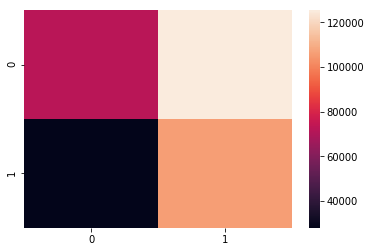

In [35]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est),
                        index = ['正解 = 失敗', '正解 = 成功'],
                        columns = ['予測 = 失敗', '予測 = 成功'])

display(conf_mat)
sns.heatmap(conf_mat)
plt.show()